# Vision models

## Orientation: ResNet-18


1. Let's start by training a simple ResNet-18 model and take lots of checkpoints.
2. Then do feature visualization on the end results (for a random sample of neurons). 
3. Look at how the activation of the target neuron reacts to those feature visualizations over the course of training.

In [5]:
import os
from dataclasses import dataclass, field
from typing import Optional, Container, Tuple, List, Dict, TypedDict
from dataclasses import asdict
import math
from typing import Callable
import functools
import random
import logging

import torch
from torch import nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
import torchvision
import torchvision.utils as vutils
from PIL import Image
from tqdm.notebook import tqdm
import numpy as np
import pandas as pd
import wandb 
from torch.optim.lr_scheduler import LambdaLR 
from dotenv import load_dotenv
import matplotlib.pyplot as plt

from devinterp.config import Config, OptimizerConfig, SchedulerConfig
from devinterp.checkpoints import CheckpointManager
from devinterp.logging import Logger
from devinterp.learner import Learner
from devinterp.misc.io import gen_images, show_images
from devinterp.viz.activations import FeatureVisualizer, ActivationProbe
from devinterp.misc.io import show_images



load_dotenv("../.env")
# wandb.finish()
logging.basicConfig(level=logging.INFO)

In [2]:
torch.manual_seed(0)
model: nn.Module = torch.hub.load('pytorch/vision:v0.10.0', 'resnet18', pretrained=False)

Using cache found in /Users/Jesse/.cache/torch/hub/pytorch_vision_v0.10.0
/Users/Jesse/Projects/devinterp/.venv/lib/python3.11/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/Users/Jesse/Projects/devinterp/.venv/lib/python3.11/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


In [131]:
# Data
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

train_transforms = transforms.Compose([
    transforms.RandomCrop(32, padding=4),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
])

train_set = datasets.CIFAR10(root='../data', train=True, download=True, transform=train_transforms)
test_set = datasets.CIFAR10(root='../data', train=False, download=True, transform=transform)

train_loader = torch.utils.data.DataLoader(train_set, shuffle=False, batch_size=512)
test_loader = torch.utils.data.DataLoader(test_set, shuffle=False, batch_size=512)

Files already downloaded and verified
Files already downloaded and verified


In [5]:
from devinterp.config import Config
import yaml


def lr_lambda(step: int):
    if step < 400:
        return 0.1
    elif step < 32_000:
        return 1.
    elif step < 48_000:
        return 0.1
    else:
        return 0.01

config = Config(
    num_training_samples=len(train_set), 
    num_steps=64_000, 
    project="resnet18", 
    entity="devinterp", 
    logging_steps=(100, 100), 
    checkpoint_steps=(25, 25),
    optimizer_config=OptimizerConfig(
        optimizer_type="SGD",
        lr=0.1,
        momentum=0.9,
    ),
    scheduler_config=SchedulerConfig(
        scheduler_type="MultiStepLR",
        milestones=[16_000, 32_000, 48_000], 
        gamma=0.5,
        lr_lambda=lr_lambda,
    ),
)

print(yaml.dump(config.model_dump(exclude=("logging_steps", "checkpoint_steps"))))

/Users/Jesse/Projects/devinterp/devinterp/utils.py:45: UserWarning: Number of steps in int_logspace is not 100, got 88.
  warnings.warn(f"Number of steps in int_logspace is not {num}, got {len(result)}.")
/Users/Jesse/Projects/devinterp/devinterp/utils.py:45: UserWarning: Number of steps in int_logspace is not 25, got 24.
  warnings.warn(f"Number of steps in int_logspace is not {num}, got {len(result)}.")
INFO:devinterp.config:Logging to wandb enabled (project: resnet18, entity: devinterp)
INFO:devinterp.config:batch_size: 128
checkpoint_steps: !!set
  0: null
  1: null
  2: null
  3: null
  6: null
  10: null
  15: null
  25: null
  40: null
  63: null
  100: null
  159: null
  252: null
  401: null
  636: null
  1008: null
  1600: null
  2537: null
  2666: null
  4023: null
  5333: null
  6381: null
  8000: null
  10119: null
  10666: null
  13333: null
  16000: null
  16047: null
  18666: null
  21333: null
  24000: null
  25448: null
  26666: null
  29333: null
  32000: null
  3466

batch_size: 128
device: cpu
entity: devinterp
num_epochs: 165
num_steps: 64000
num_training_samples: 50000
optimizer_config:
  lr: 0.1
  momentum: 0.9
  optimizer_type: SGD
  weight_decay: 0.0001
project: resnet18
scheduler_config:
  gamma: 0.5
  last_epoch: -1
  milestones:
  - 16000
  - 32000
  - 48000
  scheduler_type: MultiStepLR



In [16]:
def loss_metric(model, data, target, output):
    return F.cross_entropy(output, target, reduction="sum")

def accuracy_metric(model, data, target, output):
    pred = output.argmax(dim=1, keepdim=True)
    return pred.eq(target.view_as(pred)).sum()

def eval_learner(learner: Learner):
    return dataloaders_reduce(learner.model, {"Train": learner.train_loaders, "Test": learner.test_loaders}, {"Loss": loss_metric, "Accuracy": accuracy_metric}, device=learner.config.device)

learner = Learner(model, train_set, test_set, config, metrics=[eval_learner])
learner.train()

wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


Epoch 0 Batch 0/64000 Loss: ?.??????:   0%|          | 0/64000 [00:00<?, ?it/s]

# Feature visualization

We have a trained `model` (and a bunch of checkpoints). First, let's do some classic feature visualization on the final network. We'll select a few random neurons from ac

In [67]:
from devinterp.storage import CheckpointManager, VisualizationManager

In [66]:
checkpoints = CheckpointManager('ResNet18/CIFAR10', 'devinterp', local_root="..")
model = torchvision.models.resnet18(pretrained=False)
model.load_state_dict(checkpoints[-1]["model"])

/Users/Jesse/Projects/devinterp/.venv/lib/python3.11/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/Users/Jesse/Projects/devinterp/.venv/lib/python3.11/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)
INFO:__main__:Loading checkpoints/ResNet18/CIFAR10/checkpoint_epoch_164_batch_64000.pt from local save...


(164, 64000) checkpoints/ResNet18/CIFAR10/checkpoint_epoch_164_batch_64000.pt ../checkpoints/ResNet18/CIFAR10/checkpoint_epoch_164_batch_64000.pt


<All keys matched successfully>

In [170]:
from contextlib import contextmanager
from typing import Callable, Optional, Tuple, Union

import torch
from torch.nn import functional as F
from torchvision import transforms
from tqdm import tqdm

from devinterp.misc.io import show_images
from devinterp.storage import VisualizationManager

DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
Transform = Callable[[torch.Tensor], torch.Tensor]


class ActivationProbe:
    """
    A utility class to extract the activation value of a specific neuron within a neural network.

    The location of the target neuron is defined using a string that can specify the layer, channel, and spatial coordinates (y, x). The format allows flexibility in defining the location:

    - 'layer1.0.conv1.weight.3': Only channel is specified; y and x default to the center (or one-off from center if the width and height are even).

    The class provides methods to register a forward hook into a PyTorch model to capture the activation of the specified neuron during model inference.

    Attributes:
        model: The PyTorch model from which to extract the activation.
        location (str): The dot-separated path specifying the layer, channel, y, and x coordinates.
        activation: The value of the activation at the specified location.

    Example:
        model = ResNet18()
        extractor = ActivationProbe(model, 'layer1.0.conv1.weight.3')
        handle = extractor.register_hook()
        output = model(input_tensor)
        print(extractor.activation)  # Prints the activation value

    # TODO: Allow wildcards in the location string to extract composite activations (for an entire layer at a time).
    # TODO: Implement basic arithmetic operators so that you can combine activations (e.g. `0.4 * ActivationProbe(model, 'layer1.0.conv1.weight.3') + 0.6 * ActivationProbe(model, 'layer1.0.conv1.weight.4')`).
    """
    def __init__(self, model: nn.Module, location: str):
        self.activation = None
        self.model = model
        self.location = location.split(".")
        self.layer_path = []
        self.indices: Tuple[int, ...] = ()

        # Split the location into layer path and neuron indices
        state_dict_keys = list(model.state_dict().keys())
        for part in self.location:
            self.layer_path.append(part)
            path = ".".join(self.layer_path)

            if any(key.startswith(path) for key in state_dict_keys):
                continue
            else:
                self.layer_path.pop()
                self.indices = tuple(map(int, self.location[len(self.layer_path):]))
                break

        # Get the target layer
        self.layer = model
        for part in self.layer_path[:-1]:
            self.layer = getattr(self.layer, part)

    def hook_fn(self, module, input, output):
        if isinstance(module, nn.Linear):
            self.activation = output[0, self.indices[0]]
        elif isinstance(module, nn.Conv2d):
            y = output.size(2) // 2
            x = output.size(3) // 2

            self.activation = output[0, self.indices[0], y, x]

    def register_hook(self):
        handle = self.layer.register_forward_hook(self.hook_fn)
        return handle

    @contextmanager
    def watch(self):
        handle = self.register_hook()
        yield
        handle.remove()


@dataclass
class Visualization:
    snapshots: torch.Tensor
    location: str
    thresholds: List[int]
    activation: Optional[float] = None

    #: If provided, then this is initialized from a real sample from the original.
    index: Optional[int] = None
    #: If provided, then this is optimized from a noise sample.
    seed: Optional = None

    label: Optional[int] = None

    @property
    def last(self):
        return self.snapshots[-1]

    def append(self, image):
        self.snapshots.append(image)

    @staticmethod
    def draw(
        *visualizations, nrow: Optional[int] = None, show_evolution=False, show=False
    ):
        if show_evolution:
            images = [s for v in visualizations for s in v.snapshots]
            nrow = nrow or len(visualizations[0].snapshots)
        else:
            images = [v.last for v in visualizations]

        if show:
            return show_images(*images, nrow=nrow)
        else:
            return gen_images(*images, nrow=nrow)


class FeatureVisualizer:
    def __init__(
        self,
        model: torch.nn.Module,
        storage: Optional[VisualizationManager] = None,
    ):
        """
        Initialize the FeatureVisualizer.

        Args:
            model (torch.nn.Module): The PyTorch model for which to visualize the features.
            storage (Optional[VisualizationManager]): Manager for saving and loading visualizations.
        """
        self.model = model
        self.storage = storage

    def save_visualization(self, location: str, seed: int, step: int, data):
        if self.storage:
            file_id = (location, seed, step)
            self.storage.save_file(file_id, data)

    def load_visualization(self, location: str, seed: int, step: int):
        if self.storage:
            file_id = (location, seed, step)
            return self.storage.load_file(file_id)
        return None

    @staticmethod
    def gen_locations(
        model: torch.nn.Module,
        layer_type: Optional[Union[type, Tuple[type, ...]]] = None,
    ) -> list[str]:
        """Generate neurons of a particular kind of layer from a PyTorch model."""
        channel_locations = []

        def recursive_search(module, prefix):
            for name, submodule in module.named_children():
                path = prefix + "." + name if prefix else name

                if not layer_type or isinstance(submodule, layer_type):
                    # TODO: Check that the submodule has a 'weight' attribute.
                    # TODO: Do something about biases
                    for channel in range(submodule.out_channels):
                        location = f"{path}.weight.{channel}"
                        channel_locations.append(location)

                recursive_search(submodule, path)

        recursive_search(model, "")

        return channel_locations

    def render(
        self,
        probe: ActivationProbe,
        num_visualizations: int = 1,
        transform: Optional[Transform] = None,
        thresholds: list[int] = [512],
        verbose: bool = True,
        seed: int = 0,
        device: torch.device = DEVICE,
        diversity_weight: float = 0.1,
        maximize=True,
        lr=0.01,
        weight_decay=1e-3
    ) -> list[Visualization]:
        """Renders multiple images that maximize the activation of the specified neuron, with a penalty to increase diversity.

        Args:
            num_visualizations (int): Number of visualizations to generate.
            diversity_weight (float, optional): Weight of the diversity penalty.

        Returns:
            list[list[torch.Tensor]]: A list containing lists of final images for each visualization.
        """

        self.model.to(device)
        self.model.eval()

        # Create random images (num_visualizations x 3 x 32 x 32) to start optimization
        torch.manual_seed(seed)
        images = torch.rand(
            (num_visualizations, 3, 32, 32), requires_grad=True, device=device
        )

        # Optimizer
        optimizer = torch.optim.Adam([images], lr=lr, weight_decay=weight_decay, maximize=maximize)
        visualizations = [
            Visualization(
                [images[i].detach().clone()],
                probe.location,
                thresholds,
                seed=f"{seed}-{i}",
            )
            for i in range(num_visualizations)
        ]

        with probe.watch():
            pbar = range(max(thresholds) + 1)

            if verbose:
                pbar = tqdm(
                    pbar, desc=f"Visualizing {probe.location} (activation: ???)"
                )

            for iteration in pbar:
                optimizer.zero_grad()
                total_loss = torch.tensor(0.0, device=device)

                # TODO: parallelize the following
                for i in range(num_visualizations):
                    self.model(
                        images[i].unsqueeze(0)
                    )  # Forward pass through the model to trigger the hook
                    total_loss += probe.activation  # Maximizing activation

                    # Calculate diversity penalty for the current image
                    for j in range(num_visualizations):
                        if i != j:
                            diversity_loss = F.cosine_similarity(
                                images[i].view(1, -1), images[j].view(1, -1)
                            )[0]
                            total_loss -= diversity_weight * diversity_loss

                total_loss.backward()
                optimizer.step()

                if transform:
                    images.data = transform(images.data.detach().clone())

                if verbose:
                    pbar.set_description(
                        f"Visualizing {probe.location} (activation: {total_loss.item():.2f})"
                    )

                if iteration in thresholds:
                    for i in range(num_visualizations):
                        image = images[i].detach().clone()
                        image = torch.reshape(image, (3, 32, 32))
                        visualizations[i].append(image)

        for v in visualizations:
            self.model(v.last.unsqueeze(0))
            v.activation = probe.activation

        return visualizations

    def find_triggers(
        self,
        dataloader: torch.utils.data.DataLoader,
        probe: ActivationProbe,
        k: int,
        verbose: bool = False,
        maximize=True
    ) -> List[int]:
        """
        Find the indices of the k samples that maximally activate a given neuron.

        Args:
            dataloader (torch.utils.data.DataLoader): DataLoader providing batches of data.
            probe (ActivationProbe): ActivationProbe object for the neuron of interest.
            k (int): Number of samples to return.

        Returns:
            List[int]: Indices of the k samples that maximally activate the specified neuron.
        """
        activations = []

        with probe.watch():
            pbar = enumerate(dataloader)
            if verbose:
                pbar = tqdm(pbar, desc="Finding samples...", total=len(dataloader))

            for batch_idx, (data, _) in pbar:
                data = data.to(DEVICE)
                batch_size = data.shape[0]

                # Inefficient but whatever
                for sample_idx in range(batch_size):
                    sample_data = data[sample_idx].unsqueeze(0)
                    self.model(sample_data)
                    activations.append(probe.activation.item())

        return [
            Visualization(
                [dataloader.dataset[i][0]],
                label=dataloader.dataset[i][0],
                location=probe.location,
                activation=a,
                index=i,
                thresholds=[0],
            )
            for i, a in sorted(enumerate(activations), key=lambda x: x[1], reverse=maximize)[:k]
        ]

Visualizing ['fc', 'weight', '0'] (activation: 251.18): 100%|██████████| 257/257 [00:26<00:00,  9.84it/s]


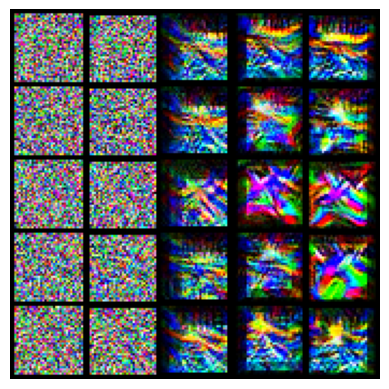

Visualizing ['fc', 'weight', '1'] (activation: 196.80):  85%|████████▍ | 218/257 [00:21<00:03,  9.99it/s]wandb: 429 encountered (Filestream rate limit exceeded, retrying in 2.2 seconds.), retrying request
Visualizing ['fc', 'weight', '1'] (activation: 207.37): 100%|██████████| 257/257 [00:25<00:00, 10.08it/s]


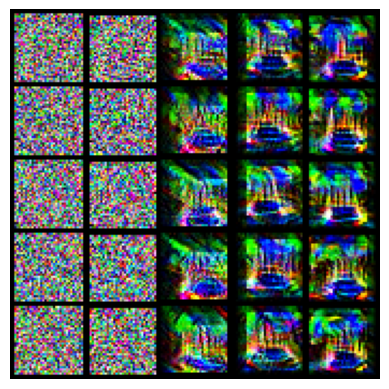

Visualizing ['fc', 'weight', '2'] (activation: 192.63):  43%|████▎     | 111/257 [00:11<00:14, 10.10it/s]wandb: 429 encountered (Filestream rate limit exceeded, retrying in 4.3 seconds.), retrying request
wandb: 429 encountered (Filestream rate limit exceeded, retrying in 10.0 seconds.), retrying request
Visualizing ['fc', 'weight', '2'] (activation: 218.43): 100%|██████████| 257/257 [00:25<00:00, 10.14it/s]


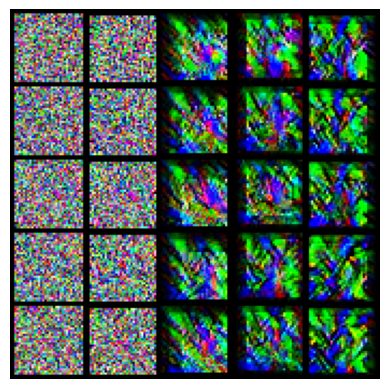

Visualizing ['fc', 'weight', '3'] (activation: 180.54):   2%|▏         | 5/257 [00:00<00:26,  9.69it/s]wandb: 429 encountered (Filestream rate limit exceeded, retrying in 2.0 seconds.), retrying request
Visualizing ['fc', 'weight', '3'] (activation: 211.59): 100%|██████████| 257/257 [00:25<00:00, 10.10it/s]


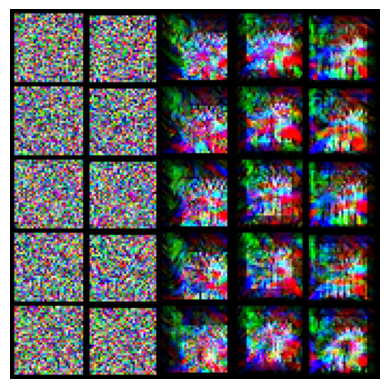

Visualizing ['fc', 'weight', '4'] (activation: 217.20): 100%|██████████| 257/257 [00:25<00:00, 10.16it/s]


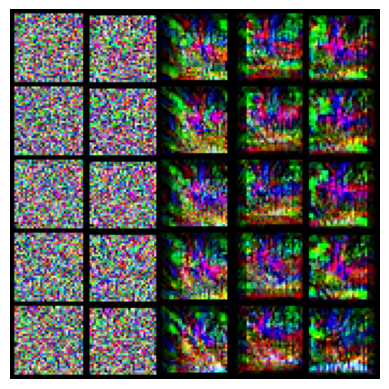

Visualizing ['fc', 'weight', '5'] (activation: 263.62): 100%|██████████| 257/257 [00:25<00:00, 10.14it/s]


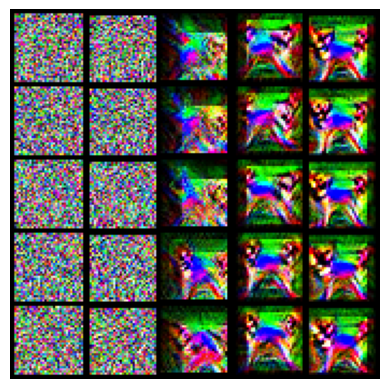

Visualizing ['fc', 'weight', '6'] (activation: 209.99): 100%|██████████| 257/257 [00:25<00:00, 10.13it/s]


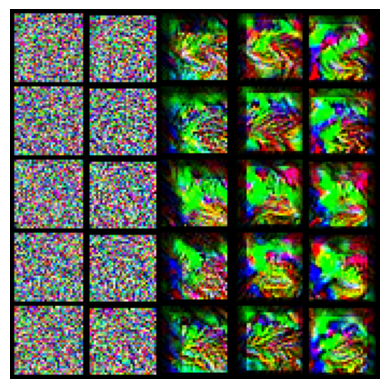

Visualizing ['fc', 'weight', '7'] (activation: 248.58): 100%|██████████| 257/257 [00:26<00:00,  9.82it/s]


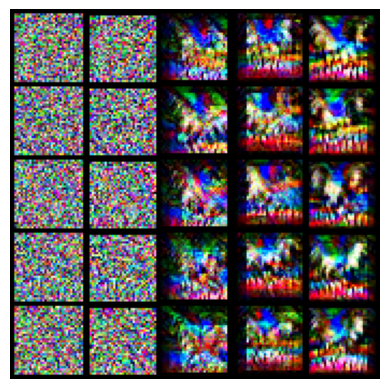

Visualizing ['fc', 'weight', '8'] (activation: 196.22): 100%|██████████| 257/257 [00:25<00:00, 10.09it/s]


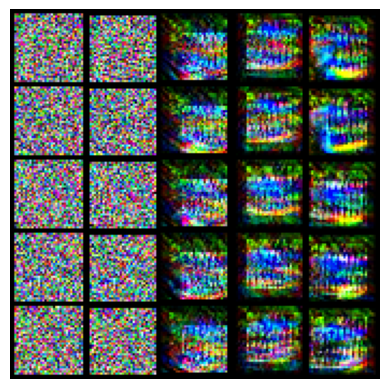

Visualizing ['fc', 'weight', '9'] (activation: 204.11): 100%|██████████| 257/257 [00:25<00:00, 10.15it/s]


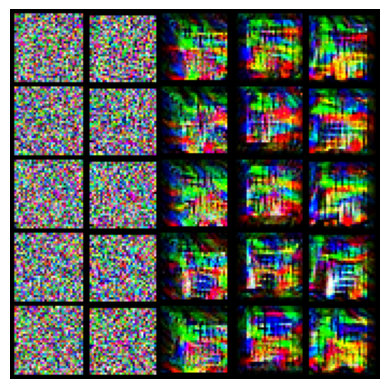

In [172]:
viz = FeatureVisualizer(model)
locations=[f"fc.weight.{i}" for i in range(10)]

# Random croppings, rotations, and noise.
transform = transforms.Compose([
    transforms.RandomCrop(32, padding=1),
    transforms.ColorJitter(brightness=0, contrast=0.0001, saturation=0.0001, hue=0.000),
    transforms.RandomRotation(0.5)
])


names = ["airplane", "automobile", "bird", "cat", "deer", "dog", "frog", "horse", "ship", "truck"]
for name, location in zip(names, locations):
    print(name)
    probe = ActivationProbe(model, location)
    optimized_visualizations = viz.render(
        probe,
        5,
        thresholds=[0, 64, 128, 256],
        device="cpu",
        diversity_weight=diversity_weight,
        transform=transform,
        lr=0.1
    )
    optimized_images = Visualization.draw(
        *optimized_visualizations, show_evolution=True, show=True
    )

In [161]:
# The diversity weight doesn't seem to be doing much for earlier layers.

wandb.init(project="resnet18-viz", entity="devinterp")
viz = FeatureVisualizer(model)
locations = [f"layer1.0.conv1.weight.{i}" for i in range(10)]

for i, location in enumerate(locations):
    probe = ActivationProbe(model, location)
    optimized_visualizations = viz.render(
        probe,
        5,
        thresholds=[0, 64, 128, 256],
        device="cpu",
        diversity_weight=diversity_weight,
    )
    optimized_images = Visualization.draw(
        *optimized_visualizations, show_evolution=True, show=False
    )

    sample_visualizations = viz.find_triggers(
        test_loader, probe, 25, verbose=True
    )
    samples = Visualization.draw(*sample_visualizations, nrow=5, show=False)

    wandb.log(
        {
            f"{location}/samples/images": wandb.Image(samples),
            f"{location}/samples/activations": [
                v.activation for v in sample_visualizations
            ],
            f"{location}/optimized/images": wandb.Image(optimized_images),
            f"{location}/optimized/activations": [
                v.activation for v in optimized_visualizations
            ],
        },
        step=0,
        commit=True
    )

Visualizing ['layer1', '0', 'conv1', 'weight', '0'] (activation: -601.76): 100%|██████████| 257/257 [00:10<00:00, 24.91it/s]
Finding samples...: 100%|██████████| 20/20 [00:59<00:00,  2.99s/it]
Visualizing ['layer1', '0', 'conv1', 'weight', '1'] (activation: -755.57): 100%|██████████| 257/257 [00:10<00:00, 24.34it/s]
Finding samples...: 100%|██████████| 20/20 [01:01<00:00,  3.05s/it]
Visualizing ['layer1', '0', 'conv1', 'weight', '2'] (activation: -691.80): 100%|██████████| 257/257 [00:11<00:00, 23.18it/s]
Finding samples...:  15%|█▌        | 3/20 [00:10<00:58,  3.43s/it]wandb: 429 encountered (Filestream rate limit exceeded, retrying in 2.0 seconds.), retrying request
wandb: 429 encountered (Filestream rate limit exceeded, retrying in 4.9 seconds.), retrying request
Finding samples...: 100%|██████████| 20/20 [01:05<00:00,  3.26s/it]
Visualizing ['layer1', '0', 'conv1', 'weight', '3'] (activation: -871.67): 100%|██████████| 257/257 [00:11<00:00, 22.77it/s]
Finding samples...: 100%|█████

wandb: 429 encountered (Filestream rate limit exceeded, retrying in 2.5 seconds.), retrying request
wandb: 429 encountered (Filestream rate limit exceeded, retrying in 4.9 seconds.), retrying request


Visualizing ['layer1', '0', 'conv1', 'weight', '0'] (activation: 602.13): 100%|██████████| 257/257 [00:10<00:00, 24.70it/s]


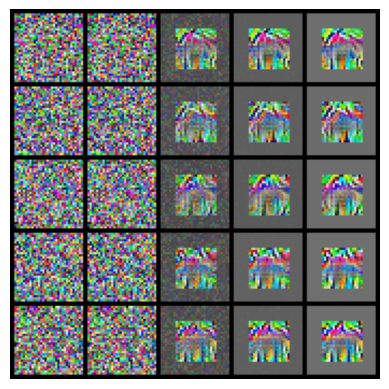

Visualizing ['layer1', '0', 'conv1', 'weight', '0'] (activation: 605.69): 100%|██████████| 257/257 [00:10<00:00, 24.94it/s]


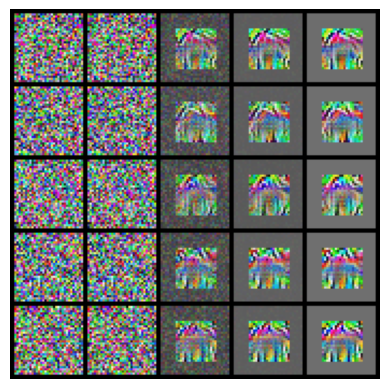

Visualizing ['layer1', '0', 'conv1', 'weight', '0'] (activation: 158.51):  28%|██▊       | 72/257 [00:03<00:07, 23.94it/s]


KeyboardInterrupt: 

In [ ]:
# The diversity weight doesn't seem to be doing much for earlier layers. 


Visualizing ['layer4', '0', 'conv2', 'weight', '0'] (activation: 0.55): 100%|██████████| 512/512 [00:09<00:00, 52.48it/s]


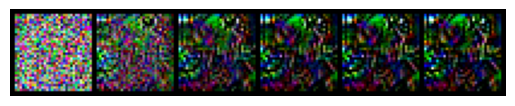

Visualizing ['layer4', '0', 'conv2', 'weight', '1'] (activation: 0.25): 100%|██████████| 512/512 [00:09<00:00, 51.69it/s]


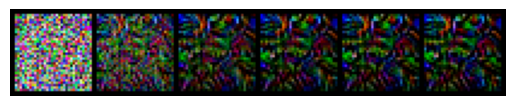

Visualizing ['layer4', '0', 'conv2', 'weight', '2'] (activation: 0.36): 100%|██████████| 512/512 [00:09<00:00, 51.58it/s]


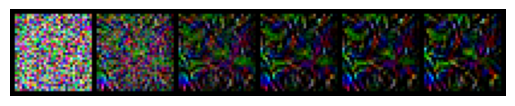

Visualizing ['layer4', '0', 'conv2', 'weight', '3'] (activation: 1.23): 100%|██████████| 512/512 [00:09<00:00, 51.50it/s]


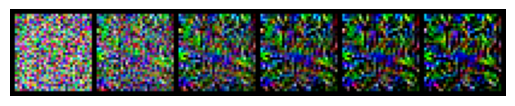

Visualizing ['layer4', '0', 'conv2', 'weight', '4'] (activation: 0.51): 100%|██████████| 512/512 [00:10<00:00, 51.03it/s]


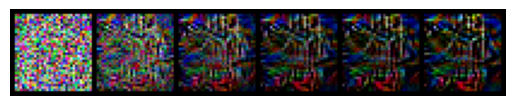

Visualizing ['layer4', '0', 'conv2', 'weight', '5'] (activation: 0.18): 100%|██████████| 512/512 [00:09<00:00, 51.22it/s]


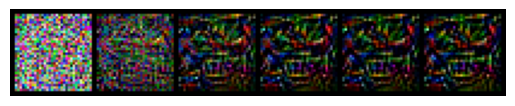

Visualizing ['layer4', '0', 'conv2', 'weight', '6'] (activation: 0.34): 100%|██████████| 512/512 [00:09<00:00, 51.26it/s]


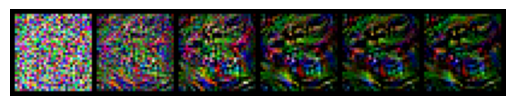

Visualizing ['layer4', '0', 'conv2', 'weight', '7'] (activation: 1.21): 100%|██████████| 512/512 [00:09<00:00, 51.27it/s]


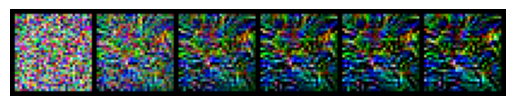

Visualizing ['layer4', '0', 'conv2', 'weight', '8'] (activation: 0.47): 100%|██████████| 512/512 [00:10<00:00, 51.14it/s]


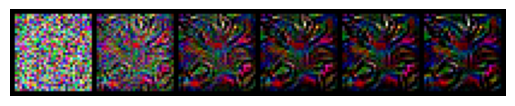

Visualizing ['layer4', '0', 'conv2', 'weight', '9'] (activation: 1.63): 100%|██████████| 512/512 [00:09<00:00, 51.30it/s]


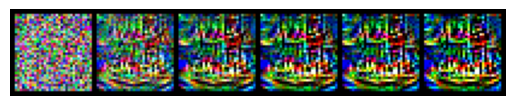

In [101]:
# What about later layers? 

viz = FeatureVisualizer(model, [f'layer4.0.conv2.weight.{i}' for i in range(10)])

# Random croppings, rotations, and noise.
transform = transforms.Compose([
    # transforms.RandomCrop(32, padding=4),
    transforms.ColorJitter(brightness=0.0001, contrast=0.0001, saturation=0.0001, hue=0.0001),
    transforms.RandomRotation(0.5)
])

for i in range(10):
    images = viz.render(viz.activations[i], thresholds=[0, 64, 128, 192, 255, 511], device="cpu", transform=transform)
    show_images(*images)

# for diversity_weight in [0, 0.03, 0.1, 0.03, 1]:
#     viz = FeatureVisualizer(model, [f'layer4.0.conv1.weight.{i}' for i in range(10)])
#     image_rows = viz.render_diverse(viz.activations[0], 5, thresholds=[0, 64, 128, 192, 255, 511], device="cpu", diversity_weight=diversity_weight)

#     for row in image_rows:
#         show_images(*row)

### Maximally active neurons

Let's go through all neurons in the model and rank them by their activation. We will then plot the top 10 most active neurons.

In [36]:
locations = FeatureVisualizer.gen_locations(viz.model, (nn.Linear, nn.Conv2d))
len(locations)

5800

In [27]:
neurons_results =  []

for i in range(0, len(conv_neurons), 10):
    section = conv_neurons[i:i+10]
    print(section)
    _results = render_multiple(model, *section, thresholds=[256], device="cuda:0", verbose=False)
    show_images(*[images[-1] for (images, _) in _results], dpi=50)
    neurons_results.extend(_results)

    if i % 100 == 0:
        print(f"Saving results at {i}")
        torch.save(neurons_results, "../visualizations/restnet-cifar10.pt")
        
        # Print the 100 most activated neurons
        print([(name, activation) for (name, (_, activation)) in sorted(zip(conv_neurons, neurons_results), key=lambda x: x[1][1], reverse=True)[:100]])

['layer1.0.conv1.weight.0', 'layer1.0.conv1.weight.1', 'layer1.0.conv1.weight.2', 'layer1.0.conv1.weight.3', 'layer1.0.conv1.weight.4', 'layer1.0.conv1.weight.5', 'layer1.0.conv1.weight.6', 'layer1.0.conv1.weight.7', 'layer1.0.conv1.weight.8', 'layer1.0.conv1.weight.9']


NameError: name 'render_multiple' is not defined

### Developmental analysis of a sample neuron

In [ ]:
sample_neuron = "layer1.1.conv1.weights.7"
viz, activation = render(model, sample_neuron, seed=0)[-1]
print(activation)
show_images(viz)

In [ ]:
pbar = tqdm(checkpoints, desc="Looping checkpoints (activation: ???)")
activations = []

for state_dict in pbar:
    model.load_state_dict(state_dict)
    extractor = ActivationExtractor(model, sample_neuron)
    handle = extractor.register_hook()

    model.eval()
    with torch.no_grad():
        model(viz) 
        activations.append(extractor.activation)
    
    pbar.set_description(f"Looping checkpoints (activation: {extractor.activation.item():.2f})")

In [ ]:
plt.plot([b for (_, b) in checkpoints.checkpoints][-5:], activations[-5:])
plt.xlabel("Training step")
plt.ylabel("Activation")

In [ ]:
# Let's do feature visualization at the very start, at 90  steps (where it reaches a minimum) at 5k steps where it's close to 0, at 8600, at 9000, and at the last step. 

# First let's get the closest checkpoints to these steps

ideal_checkpoint_steps = [90, 5000, 8600, 9000, 9999]

def get_closest_checkpoint(checkpoints: list[tuple[int, int]], step: int) -> int:
    return min([chkpt for chkpt in checkpoints], key=lambda x: abs(x[1] - step))

checkpoint_steps = [get_closest_checkpoint(checkpoints.checkpoints, step) for step in ideal_checkpoint_steps]
checkpoint_steps

In [ ]:
for (epoch, batch_idx) in tqdm(checkpoint_steps, desc="Going through checkpoints"):
    model.load_state_dict(checkpoints[(epoch, batch_idx)])
    vizs, activation = render(model, sample_neuron, seed=0, thresholds=[0, 64, 128, 256, 512], verbose=True)
    show_images(*vizs)

### Let's do a whole set of neurons

In [ ]:
viz_results = torch.load("../visualizations/restnet-cifar10.pt", map_location=torch.device('cpu'))
viz_results = sorted([(name, a, img) for (img, a), name in zip(viz_results, conv_neurons)], key=lambda x: x[1])

In [ ]:
import numpy as np
from matplotlib import pyplot as plt

eps = 1e-4
large_eps = 100

activations = [a for _, a, _ in viz_results]

print("# Negative activations: ", len([a for a in activations if a < 0]))
print("# Zero activations: ", len([a for a in activations if a == 0]))
print("# Insignificant positive activations: ", len([a for a in activations if 0 < a <= eps]))
print("# Moderate positive activations: ", len([a for a in activations if eps < a <= large_eps]))
print("# Large positive activations: ", len([a for a in activations if large_eps < a]))

activations = [a for a in activations if a > eps]

log_bins = np.logspace(np.log10(min(activations)),
                       np.log10(max(activations)), num=10)

# Plotting the histogram
plt.hist(activations, bins=log_bins)
plt.xscale('log') # Optional, if you want the x-axis to be logarithmic


In [ ]:
# Choose 5 from each category by random
np.random.seed(2)

sample_neurons = [
    *np.random.choice([n for n, a, _ in viz_results if a < -eps], size=5, replace=False),
    *np.random.choice([n for n, a, _ in viz_results if -eps <= a <= eps], size=5, replace=False),
    *np.random.choice([n for n, a, _ in viz_results if eps < a <= large_eps], size=5, replace=False),
    *np.random.choice([n for n, a, _ in viz_results if large_eps < a], size=5, replace=False),
]
print(sample_neurons)
images = [imgs[-1] for n, _, imgs in viz_results if n in sample_neurons]
show_images(
    *images,
    nrow=5
)

In [ ]:
def evolve_multiple(model: nn.Module, checkpoints: CheckpointManager, *locations: str, opt_steps: int = 512, **kwargs):
    model.load_state_dict(checkpoints[-1])
    model.eval()

    final_vizs: dict[str, torch.Tensor] = {}
    vizs: dict[str, list[torch.Tensor]] = {}
    activations: dict[str, list[float]] = {}
   
    # Create the visualizations for the last checkpoint
    for location, _location_vizs in zip(locations, tqdm(render_multiple(model, *locations, thresholds=[opt_steps], **kwargs), desc="Creating initial visualizations")):
        final_vizs[location] = _location_vizs[0][0]
        vizs[location] = []
        activations[location] = []
 
    for i, state_dict in enumerate(tqdm(checkpoints, desc="Visiting checkpoints")):
        batch_idx = checkpoints.checkpoints[i][1]

        # Render the visualization for the next checkpoint
        model.load_state_dict(state_dict)

        for location in locations:
            viz = final_vizs[location]

            model.load_state_dict(state_dict)
            extractor = ActivationExtractor(model, location)
            handle = extractor.register_hook()

            with torch.no_grad():
                model(viz) 
                activations[location].append(extractor.activation.item())

            handle.remove()

        wandb.log({f"Activations/{location}": activations[location][-1] for location in locations}, step=batch_idx, commit=False)
            
        # Visualize this checkpoint
        if i % 20 or i == len(checkpoints) - 1:
            for location, _location_vizs in zip(locations, tqdm(render_multiple(model, *locations, thresholds=[opt_steps], **kwargs), desc=f"Creating visualizations for batch {batch_idx}")):
                viz = _location_vizs[0][0]
                vizs[location].append(viz)
                image_np = gen_images(viz)
                image = wandb.Image(image_np, caption=f"Optimized {location} at batch {batch_idx}")

                wandb.log({f"Visualizations/{location}": image}, step=batch_idx)

    return vizs, activations


In [ ]:
# wandb.finish()
# run_id = input("Run ID: ")
wandb.init(project=config.project, entity=config.entity)
results = evolve_multiple(model, checkpoints, *sample_neurons, device="cpu", verbose=False)

In [ ]:
['layer3.0.conv2.weight.206', 'layer3.0.conv1.weight.149', 'layer3.0.conv1.weight.118', 'layer3.0.conv2.weight.63', 'layer2.0.conv1.weight.102', 'layer2.0.conv2.weight.110', 'layer2.0.conv1.weight.15', 'layer3.1.conv1.weight.20', 'layer2.0.conv2.weight.19', 'layer3.0.conv1.weight.205', 'layer1.0.conv2.weight.54', 'layer2.0.conv2.weight.12', 'layer2.0.downsample.0.weight.99', 'layer1.0.conv2.weight.0', 'layer1.0.conv1.weight.47', 'layer1.0.conv2.weight.41', 'layer1.0.conv2.weight.51', 'layer3.0.downsample.0.weight.125', 'layer2.0.conv1.weight.108', 'layer1.1.conv2.weight.32']


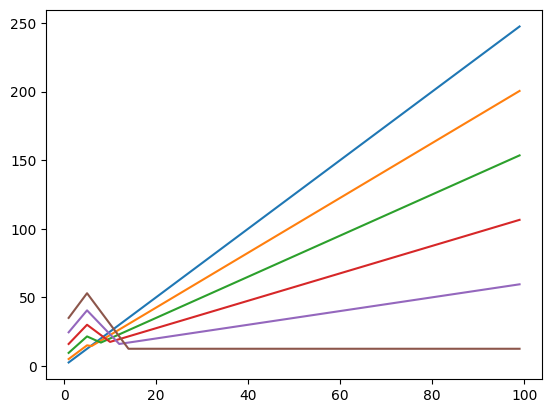

(5, [12.5, 15.0, 21.5, 30.0, 40.5, 53.0])
(10, [25.0, 22.5, 20.0, 17.5, 23.0, 30.5])
(20, [50.0, 42.5, 35.0, 27.5, 20.0, 12.5])
(50, [125.0, 102.5, 80.0, 57.5, 35.0, 12.5])
(100, [250.0, 202.5, 155.0, 107.5, 60.0, 12.5])


In [15]:
import matplotlib.pyplot as plt
import numpy as np

def lambda_reduced_rank_regression(N, M, H, r):
    def _lambda_reduced_rank_regression(N, M, H, r, s):
        return ((N + M) * r - r ** 2  + s * (N - r) + (M - r - s) * (H - r - s)) / 2

    return max(_lambda_reduced_rank_regression(N, M, H, r, s) for s in range(0, min(M + r, H + r)))

ws = np.arange(1, 100)
lambdas = [[lambda_reduced_rank_regression(5, 5, w, r) for r in range(6)] for w in ws]
# print(*zip(ws, lambdas), sep="\n")
# print([lambda_reduced_rank_regression(5, 5, 10, r) for r in range(6)])

plt.plot(ws, lambdas)
plt.show()

ws = [5, 10, 20, 50, 100]
lambdas = [[lambda_reduced_rank_regression(5, 5, w, r) for r in range(6)] for w in ws]
print(*zip(ws, lambdas), sep="\n")